## Introduction
Bienvenue dans ce projet passionnant, réalisé par **Malak Zaidi** ! 🎉  
L'objectif est d'utiliser l'algorithme **K-Nearest Neighbors (KNN)** pour classer des champignons comme **comestibles (edible)** ou **toxiques (poisonous)** à partir du jeu de données Agaricus Lepiota de l'UCI Machine Learning Repository.  

### Qu'est-ce que KNN ?
KNN est un algorithme d'apprentissage supervisé simple mais puissant, utilisé pour la classification et la régression. Voici comment il fonctionne :
- **Principe** : Pour classer un nouvel échantillon, KNN identifie les `k` échantillons les plus proches (voisins) dans l'ensemble d'entraînement, en utilisant une mesure de distance (par exemple, euclidienne, Manhattan, etc.). La classe majoritaire parmi ces voisins est attribuée au nouvel échantillon.
- **Rôle de K** : Le paramètre `k` détermine le nombre de voisins à considérer. Un `k` petit (par exemple, `k=1`) rend le modèle très sensible aux données locales (risque de surapprentissage), tandis qu'un `k` grand rend le modèle plus général (mais peut lisser les frontières de décision).
- **Rôle de la Distance** : La distance mesure la similarité entre les échantillons. Les distances courantes incluent :
  - **Euclidienne** : Distance "en ligne droite" (racine carrée de la somme des différences au carré).
  - **Manhattan** : Distance "en grille" (somme des différences absolues).
  - **Minkowski** : Généralisation des deux précédentes (paramétrée par un exposant).
Le choix de la distance influence la façon dont les voisins sont sélectionnés, surtout dans des espaces de données complexes.

Dans ce projet, nous allons :
1. Explorer les données et leurs corrélations.
2. Visualiser les données avec PCA en 2D et 3D.
3. Tester différentes valeurs de `k` et distances pour optimiser KNN.
4. Analyser l'importance des features avec SHAP et permutation importance.
5. Comparer KNN avec un autre modèle (Random Forest).
6. Visualiser les frontières de décision pour comprendre l'impact de `k` et de la distance.

Prêt à plonger dans l'univers des champignons ? 🍄

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.decomposition import PCA
import ipywidgets as widgets
from IPython.display import display, Markdown
from sklearn.inspection import permutation_importance

## Chargement et Préparation du dataset

In [47]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]



In [48]:
try:
    mushroom_data = pd.read_csv(url, header=None, names=column_names)
except Exception as e:
    print(f"Erreur lors du téléchargement : {e}")
    exit()

mushroom_data.replace('?', np.nan, inplace=True)
mushroom_data['stalk-root'] = mushroom_data['stalk-root'].fillna(mushroom_data['stalk-root'].mode()[0])


le = LabelEncoder()
for column in mushroom_data.columns:
    mushroom_data[column] = le.fit_transform(mushroom_data[column])

print(f"Nombre de doublons dans les données : {mushroom_data.duplicated().sum()}")
mushroom_data = mushroom_data.drop_duplicates()

X = mushroom_data.drop('class', axis=1)
y = mushroom_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Nombre de doublons dans les données : 0


## Corrélation des features
Voyons quelles features influencent le plus la classe (edible/poisonous) !

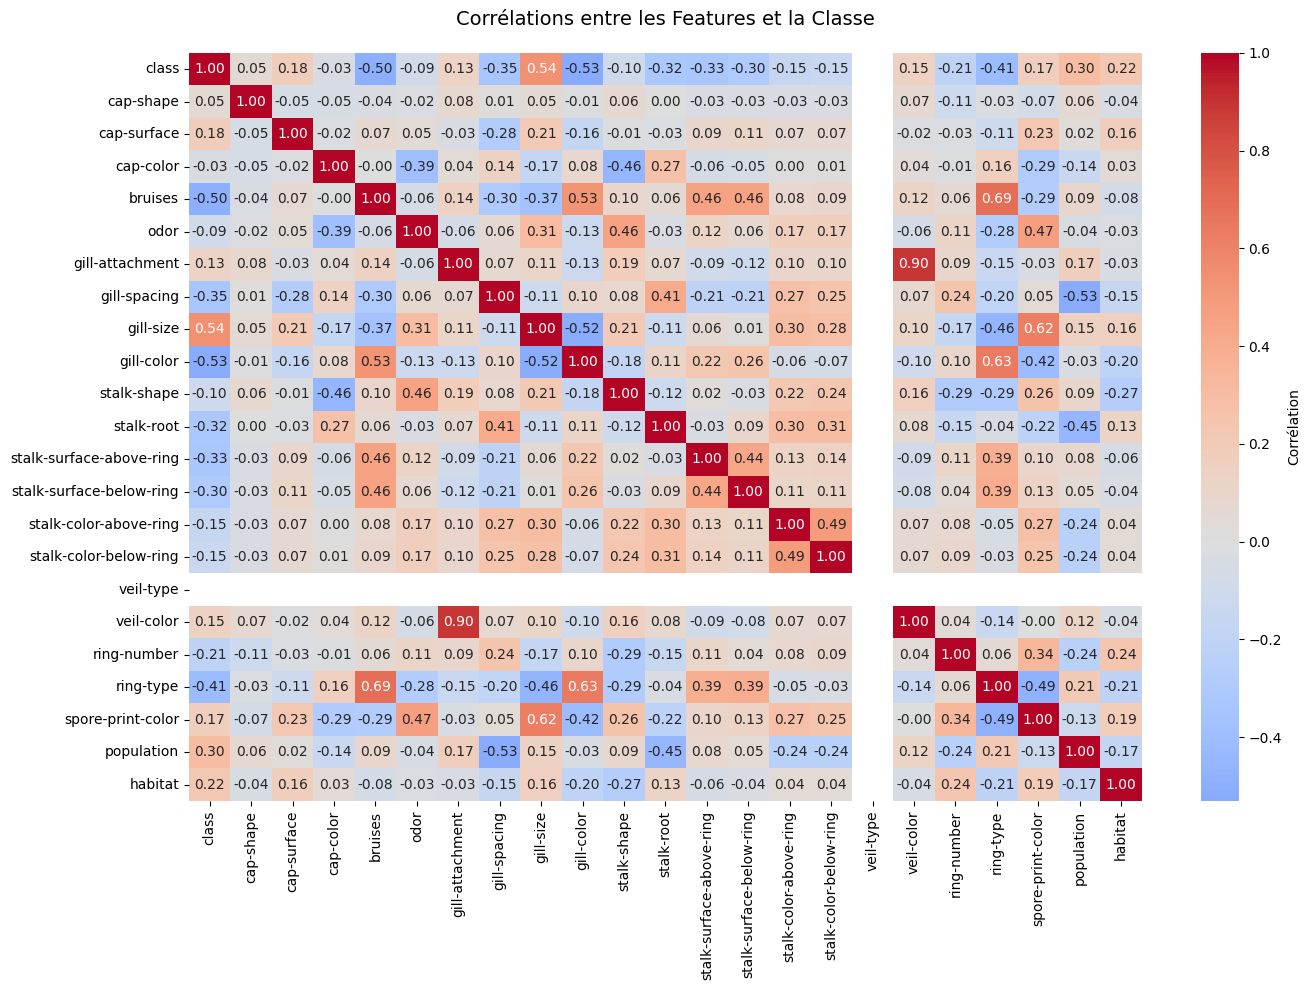

In [49]:
plt.figure(figsize=(14, 10))
sns.heatmap(mushroom_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Corrélation'})
plt.title("Corrélations entre les Features et la Classe", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Suppression des Features Inutiles

In [50]:
variances = X.var()
print("Variance des features :\n", variances)
low_variance_features = variances[variances < 0.1].index.tolist()
features_dropped_df = pd.DataFrame({
    'Feature': ['odor', 'spore-print-color'] + low_variance_features,
    'Variance': [variances.get(feat, 'N/A') for feat in ['odor', 'spore-print-color'] + low_variance_features]
})
display(features_dropped_df)
features_to_drop = ['odor', 'spore-print-color'] + low_variance_features
X = X.drop(columns=features_to_drop, errors='ignore')
print("\nFeatures conservées :", X.columns.tolist())

Variance des features :
 cap-shape                    2.573872
cap-surface                  1.512586
cap-color                    6.481204
bruises                      0.242900
odor                         4.425676
gill-attachment              0.025184
gill-spacing                 0.135432
gill-size                    0.213624
gill-color                  12.534142
stalk-shape                  0.245513
stalk-root                   0.660396
stalk-surface-above-ring     0.386212
stalk-surface-below-ring     0.456941
stalk-color-above-ring       3.616643
stalk-color-below-ring       3.637761
veil-type                    0.000000
veil-color                   0.058888
ring-number                  0.073476
ring-type                    3.246022
spore-print-color            5.677084
population                   1.567709
habitat                      2.958316
dtype: float64


,Feature,Variance
0,odor,4.425676
1,spore-print-color,5.677084
2,gill-attachment,0.025184
3,veil-type,0.000000
4,veil-color,0.058888
5,ring-number,0.073476



Features conservées : ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-type', 'population', 'habitat']


In [51]:
X = X + np.random.normal(0, 0.05, X.shape)

## Clusters avec PCA
Réduisons les données à 2D pour voir si les classes forment des clusters distincts.

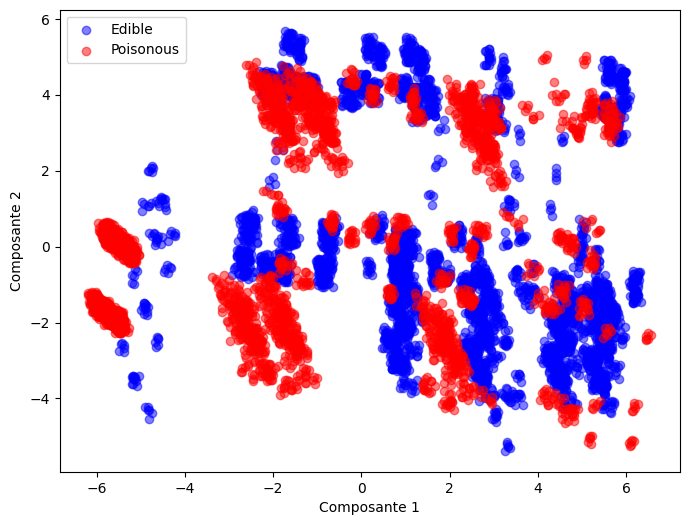

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Edible', alpha=0.5, c='blue')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Poisonous', alpha=0.5, c='red')
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.legend()
plt.show()

## Réduction de Dimensionnalité avec PCA (2D et 3D)

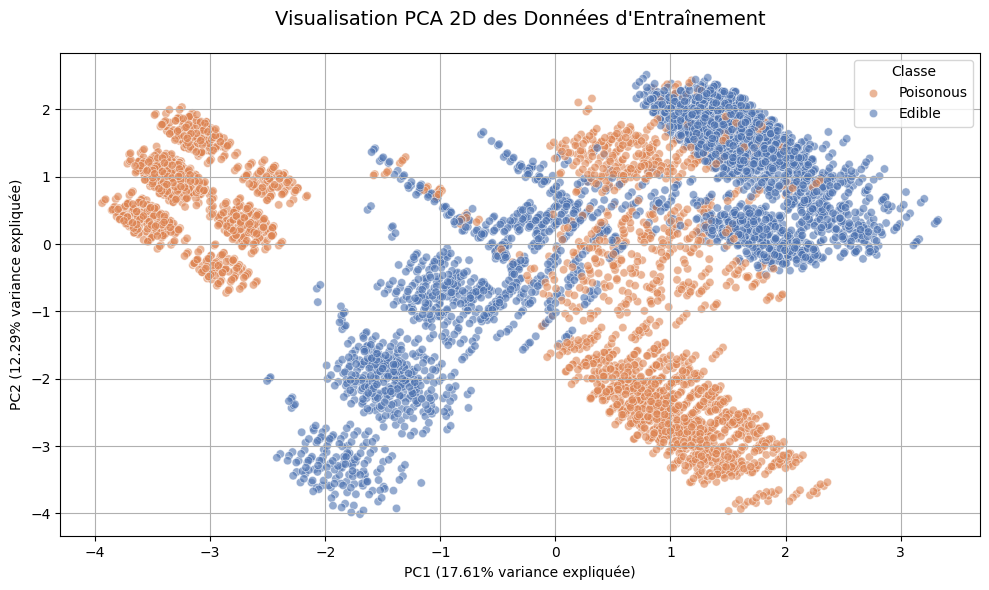

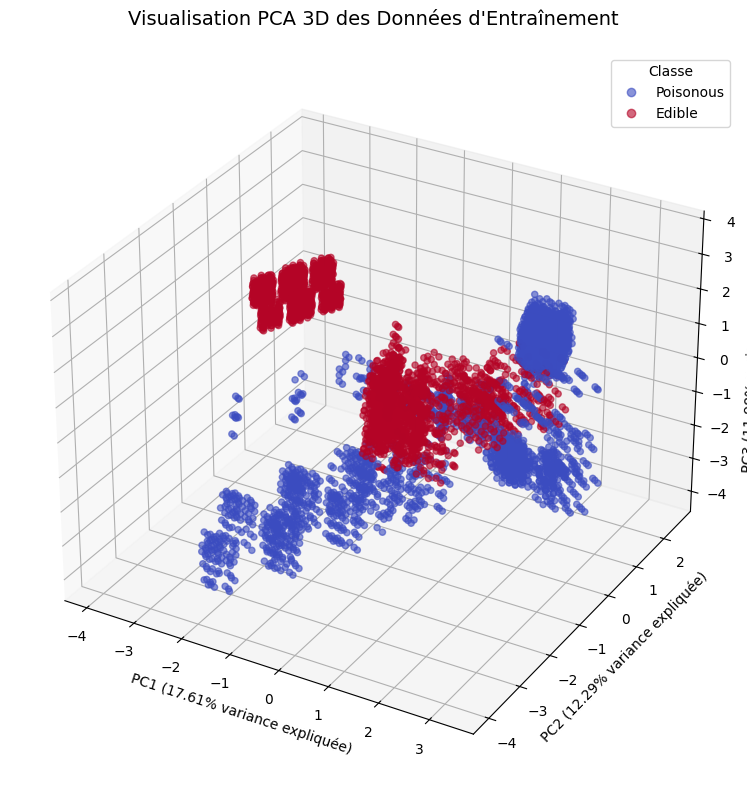

In [53]:
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y_train, palette='deep', alpha=0.6)

plt.title("Visualisation PCA 2D des Données d'Entraînement", fontsize=14, pad=20)
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance expliquée)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance expliquée)")
plt.legend(title='Classe', labels=['Poisonous', 'Edible'])
plt.grid(True)
plt.tight_layout()
plt.show()

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y_train, cmap='coolwarm', alpha=0.6)
ax.set_title("Visualisation PCA 3D des Données d'Entraînement", fontsize=14, pad=20)
ax.set_xlabel(f"PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance expliquée)")
ax.set_ylabel(f"PC2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance expliquée)")
ax.set_zlabel(f"PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance expliquée)")

handles, _ = scatter.legend_elements()
ax.legend(handles=handles, labels=['Poisonous', 'Edible'], title="Classe", loc="upper right")

plt.tight_layout()
plt.show()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
def evaluate_knn(X, y, k_values, distance_configs, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {name: {k: {'accuracy': [], 'recall': [], 'f1': []}
               for k in k_values} for name in distance_configs.keys()}
    best_model = {'recall': 0, 'k': None, 'distance': None, 'model': None}

    for train_idx, test_idx in cv.split(X, y):
        X_train_cv, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_val = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_cv_scaled = scaler.fit_transform(X_train_cv)
        X_val_scaled = scaler.transform(X_val)

        for name, params in distance_configs.items():
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, **params)
                knn.fit(X_train_cv_scaled, y_train_cv)
                y_pred = knn.predict(X_val_scaled)

                results[name][k]['accuracy'].append(accuracy_score(y_val, y_pred))
                results[name][k]['recall'].append(recall_score(y_val, y_pred, average='weighted'))
                results[name][k]['f1'].append(f1_score(y_val, y_pred, average='weighted'))

                rec = results[name][k]['recall'][-1]
                if rec > best_model['recall']:
                    best_model.update({'recall': rec, 'k': k, 'distance': name, 'model': knn})

    summary = {name: {k: {metric: (np.mean(scores), np.std(scores))
                          for metric, scores in metrics.items()}
                      for k, metrics in results[name].items()}
               for name in distance_configs.keys()}
    return summary, best_model

In [56]:
k_values = [3, 5, 7, 9, 11, 15]
distance_configs = {
    'Euclidean': {'metric': 'minkowski', 'p': 2},
    'Manhattan': {'metric': 'minkowski', 'p': 1},
    'Minkowski p=1.5': {'metric': 'minkowski', 'p': 1.5}
}

In [57]:
results, best_model = evaluate_knn(X_train, y_train, k_values, distance_configs)

## Performance vs K
Comparaison des performances pour différentes distances

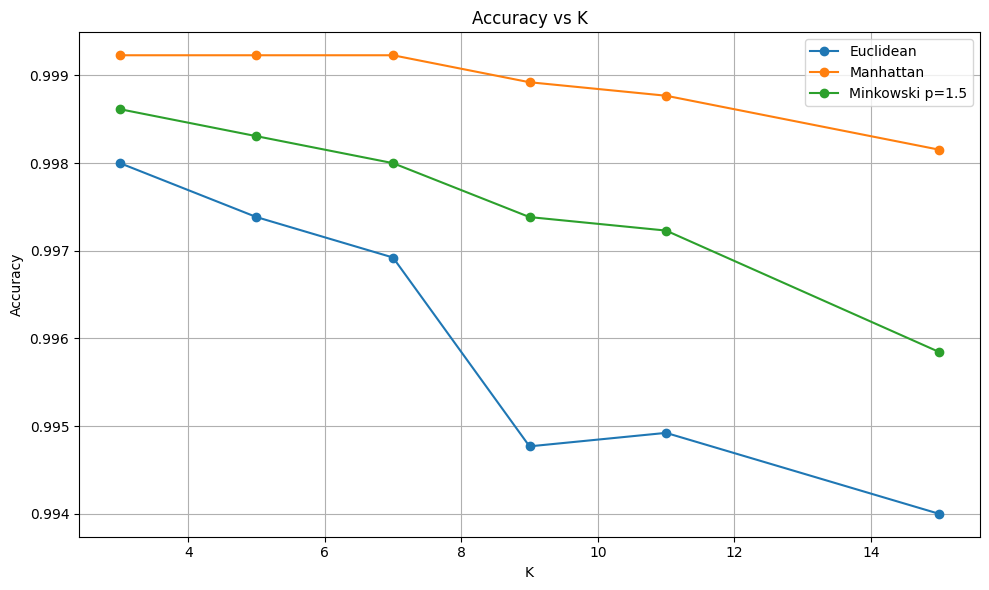

In [58]:
plt.figure(figsize=(10, 6))

plt.title('Accuracy vs K')
for name in distance_configs.keys():
    values = [results[name][k]['accuracy'][0] for k in k_values]
    plt.plot(k_values, values, label=name, marker='o')

plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 ## Frontières de Décision avec Différents K et Distances
 Pour comprendre l'impact de `k` et de la distance, visualisons les frontières de décision sur un sous-ensemble des données (projeté sur PC1 et PC2)

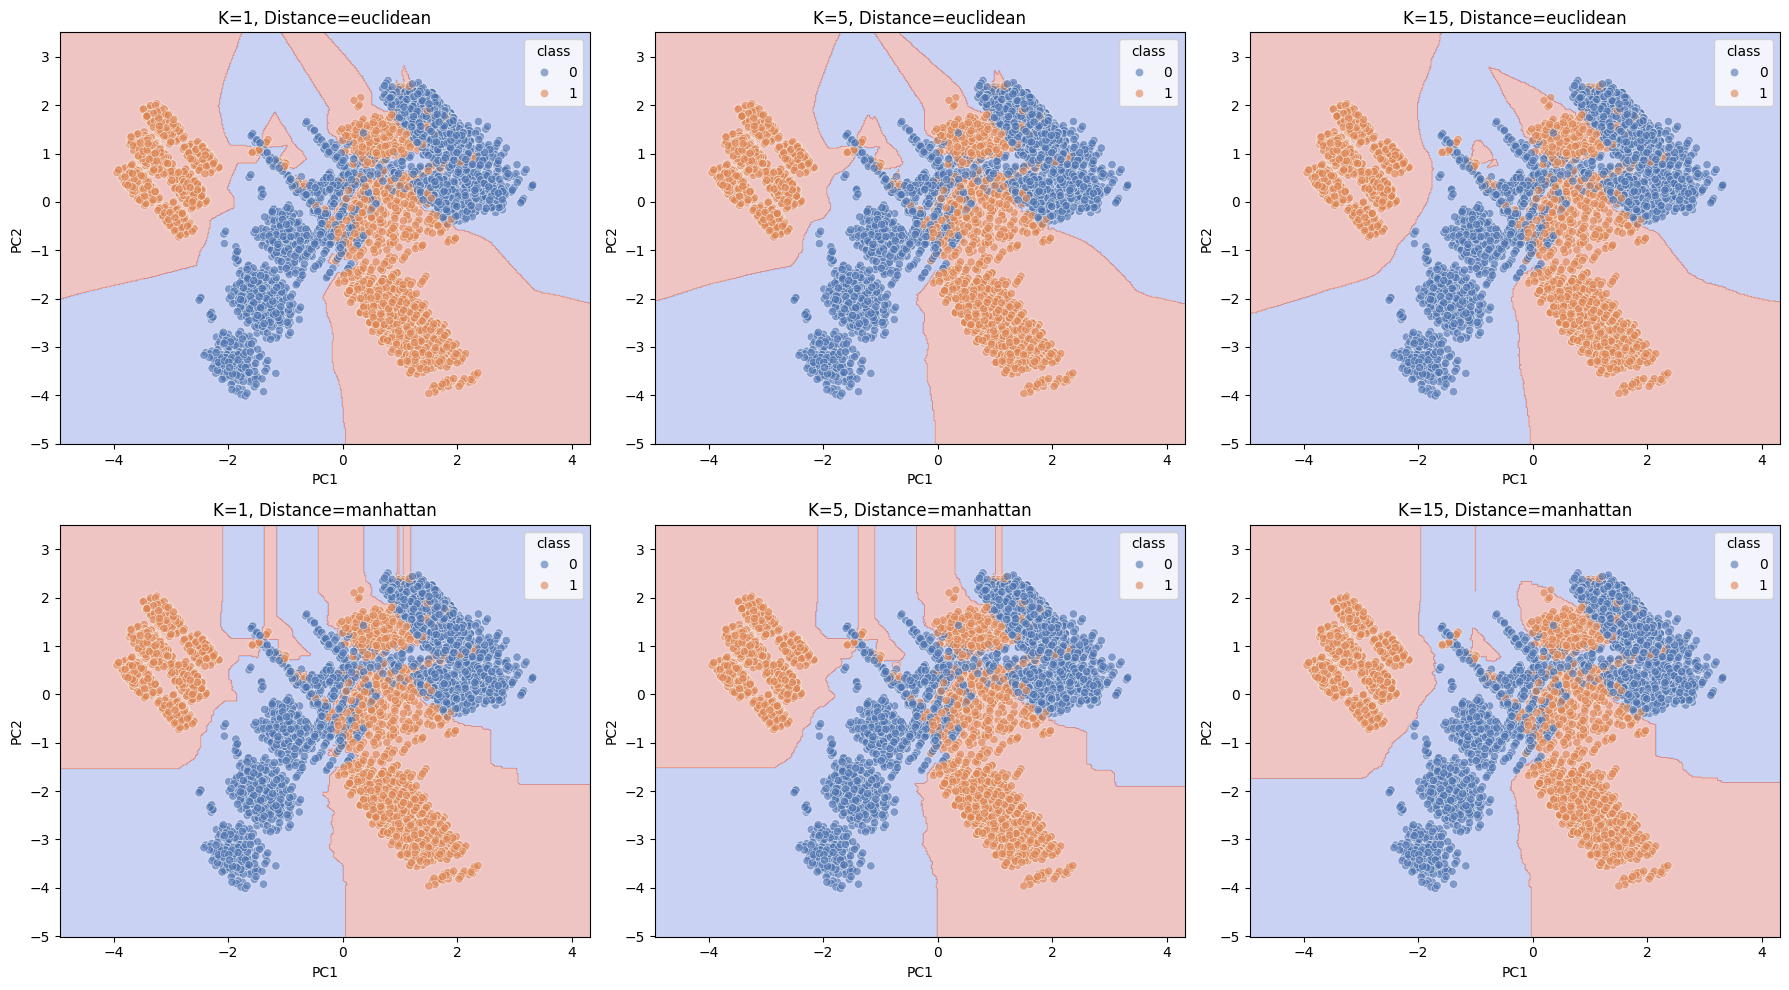

In [59]:
X_pca_train = pca_2d.transform(X_train_scaled)

def plot_decision_boundary(k, metric, ax):
    knn_temp = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn_temp.fit(X_pca_train, y_train)
    h = 0.02
    x_min, x_max = X_pca_train[:, 0].min() - 1, X_pca_train[:, 0].max() + 1
    y_min, y_max = X_pca_train[:, 1].min() - 1, X_pca_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = knn_temp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    sns.scatterplot(x=X_pca_train[:, 0], y=X_pca_train[:, 1], hue=y_train, palette='deep', ax=ax, alpha=0.6)
    ax.set_title(f"K={k}, Distance={metric}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
k_values = [1, 5, 15]
metrics = ['euclidean', 'manhattan']
for i, metric in enumerate(metrics):
    for j, k in enumerate(k_values):
        plot_decision_boundary(k, metric, axes[i, j])
plt.tight_layout()
plt.show()

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_knn = best_model['model']
y_pred_test = best_knn.predict(X_test_scaled)

In [61]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
test_cm = confusion_matrix(y_test, y_pred_test)

## Exploration des Performances KNN
Comparaison des performances pour différents K et distances

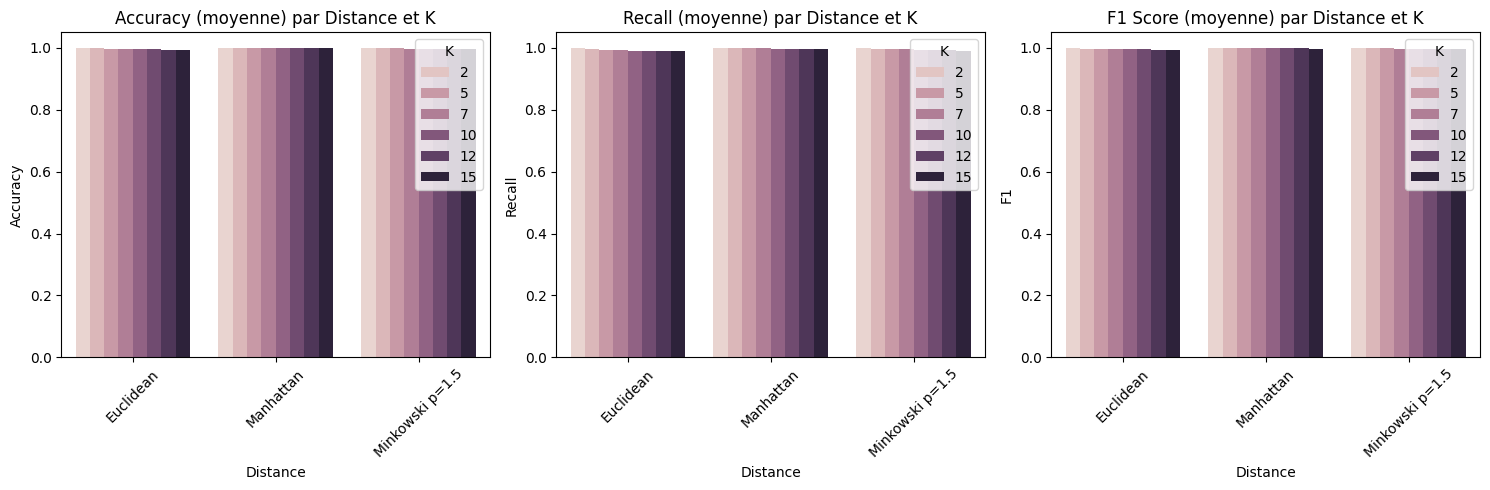

### Résultats de la Validation Croisée sur le Train Set

,K,Distance,Accuracy,Recall,F1
0,1,Euclidean,0.9989 (±0.0004),0.9987 (±0.0012),0.9989 (±0.0004)
1,1,Manhattan,1.0000 (±0.0000),1.0000 (±0.0000),1.0000 (±0.0000)
2,1,Minkowski p=1.5,0.9994 (±0.0006),0.9994 (±0.0013),0.9994 (±0.0006)
3,3,Euclidean,0.9978 (±0.0017),0.9955 (±0.0036),0.9978 (±0.0018)
4,3,Manhattan,0.9991 (±0.0015),0.9981 (±0.0031),0.9990 (±0.0016)
5,3,Minkowski p=1.5,0.9986 (±0.0016),0.9971 (±0.0034),0.9986 (±0.0017)
6,5,Euclidean,0.9966 (±0.0021),0.9933 (±0.0044),0.9965 (±0.0022)
7,5,Manhattan,0.9991 (±0.0015),0.9981 (±0.0031),0.9990 (±0.0016)
8,5,Minkowski p=1.5,0.9980 (±0.0022),0.9959 (±0.0045),0.9979 (±0.0022)
9,7,Euclidean,0.9966 (±0.0022),0.9930 (±0.0046),0.9965 (±0.0023)


Meilleur modèle (basé sur validation croisée) : K=1, Distance=manhattan (Accuracy moyenne = 100.00%)


### Résultats sur le Test Set (K=1, Distance=manhattan)

Metric,Value
Accuracy,99.94%
Recall,99.87%
F1,99.94%


In [63]:

from sklearn.model_selection import cross_val_score

# Configurations
configurations = [
    {'k': k, 'distance': distance}
    for k in [1, 3, 5, 7, 9, 11, 13, 15]
    for distance in ['Euclidean', 'Manhattan', 'Minkowski p=1.5']
]

distance_configs = {
    'Euclidean': {'metric': 'euclidean'},
    'Manhattan': {'metric': 'manhattan'},
    'Minkowski p=1.5': {'metric': 'minkowski', 'p': 1.5}
}

# Initialiser la liste des résultats
results = []

# Validation croisée pour chaque configuration
for config in configurations:
    k = config['k']
    distance = config['distance']

    params = distance_configs[distance].copy()
    params['n_neighbors'] = k

    knn = KNeighborsClassifier(**params)

    # Validation croisée sur le train set (5 folds)
    accuracies = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    recalls = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='recall')
    f1_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='f1')

    # Stocker les moyennes et écarts-types
    results.append({
        'K': k,
        'Distance': distance,
        'Accuracy': np.mean(accuracies),
        'Accuracy_std': np.std(accuracies),
        'Recall': np.mean(recalls),
        'Recall_std': np.std(recalls),
        'F1': np.mean(f1_scores),
        'F1_std': np.std(f1_scores)
    })

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(results)

# Visualisation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Distance', y='Accuracy', hue='K', data=results_df)
plt.title('Accuracy (moyenne) par Distance et K')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 3, 2)
sns.barplot(x='Distance', y='Recall', hue='K', data=results_df)
plt.title('Recall (moyenne) par Distance et K')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 3, 3)
sns.barplot(x='Distance', y='F1', hue='K', data=results_df)
plt.title('F1 Score (moyenne) par Distance et K')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Afficher les résultats avec écarts-types
results_df_display = results_df.copy()
results_df_display['Accuracy'] = results_df_display.apply(lambda row: f"{row['Accuracy']:.4f} (±{row['Accuracy_std']:.4f})", axis=1)
results_df_display['Recall'] = results_df_display.apply(lambda row: f"{row['Recall']:.4f} (±{row['Recall_std']:.4f})", axis=1)
results_df_display['F1'] = results_df_display.apply(lambda row: f"{row['F1']:.4f} (±{row['F1_std']:.4f})", axis=1)
results_df_display = results_df_display.drop(columns=['Accuracy_std', 'Recall_std', 'F1_std'])
display(Markdown("### Résultats de la Validation Croisée sur le Train Set"))
display(results_df_display.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
]).set_caption("Performances moyennes (±écart-type) sur 5 folds"))

# Trouver le meilleur modèle basé sur l'accuracy moyenne
best_idx = results_df['Accuracy'].idxmax()
best_model = results_df.loc[best_idx]
best_k = int(best_model['K'])
best_distance = best_model['Distance'].lower()

print(f"Meilleur modèle (basé sur validation croisée) : K={best_k}, Distance={best_distance} (Accuracy moyenne = {best_model['Accuracy']:.2%})")

# Entraîner le meilleur modèle sur tout le train set et tester sur le test set
params = distance_configs[best_model['Distance']].copy()
params['n_neighbors'] = best_k
knn = KNeighborsClassifier(**params)
knn.fit(X_train_scaled, y_train)
y_pred_test = knn.predict(X_test_scaled)

# Calculer les métriques sur le test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Afficher les résultats sur le test set
test_results = {
    'Metric': ['Accuracy', 'Recall', 'F1'],
    'Value': [f"{test_accuracy:.2%}", f"{test_recall:.2%}", f"{test_f1:.2%}"]
}
test_df = pd.DataFrame(test_results)
display(Markdown(f"### Résultats sur le Test Set (K={best_k}, Distance={best_distance})"))
display(test_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
]).hide(axis='index'))
